In [77]:
import sys
sys.path.append('../')

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from csbdeep.utils import normalize
from glob import glob
from skimage import io
from skimage.measure import label
from tqdm import tqdm

In [53]:
image_dir = f'../images'
merfish_dir = f'{image_dir}/merfish'

In [54]:
# Load images in train dirs
merfish_image_names = sorted(glob(f'{merfish_dir}/train/images/*.tif'))
merfish_images = [normalize(img, 1, 99.8, axis=(0, 1)) for img in list(map(io.imread, merfish_image_names))]

In [88]:
# Load masks in train dirs
merfish_mask_names = sorted(glob(f'{merfish_dir}/train/masks/manual/*.tif'))
merfish_masks = [normalize(img, 1, 99.8, axis=(0, 1)) for img in list(map(io.imread, merfish_mask_names))]

# Test Augmenters

Augmenters can be added as a parameter during training for StarDist. The augmentation will be applied to each batch of the data generator.

In [20]:
# Random flip /rotation augmenter, from: https://nbviewer.jupyter.org/github/stardist/stardist/blob/master/examples/2D/2_training.ipynb
def random_fliprot(img, mask): 
    axes = tuple(range(mask.ndim))
    rng = np.random.default_rng(586)
    perm = tuple(rng.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

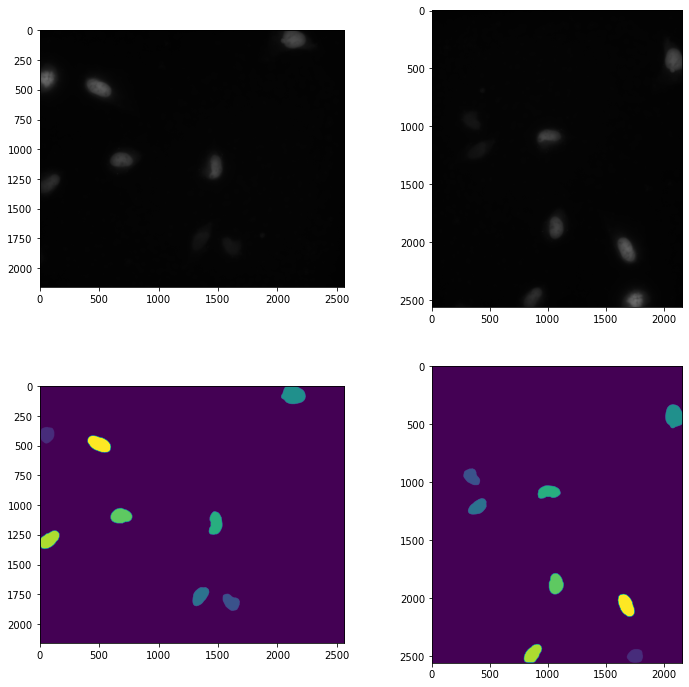

In [34]:
# Example output
figure, figure_axes = plt.subplots(2, 2, figsize = (12, 12))
figure_axes[0][0].imshow(merfish_images[3])
img, mask = random_fliprot(merfish_images[3], merfish_masks[3])
figure_axes[0][1].imshow(img)
figure_axes[1][0].imshow(merfish_masks[3])
figure_axes[1][1].imshow(mask);

In [21]:
# Random intensity (brightness / contrast) augmenter, from: https://nbviewer.jupyter.org/github/stardist/stardist/blob/master/examples/2D/2_training.ipynb
def random_intensity_change(img):
    rng = np.random.default_rng(851)
    img = img * rng.uniform(0.5, 2) + rng.uniform(-0.2, 0.2)
    return img

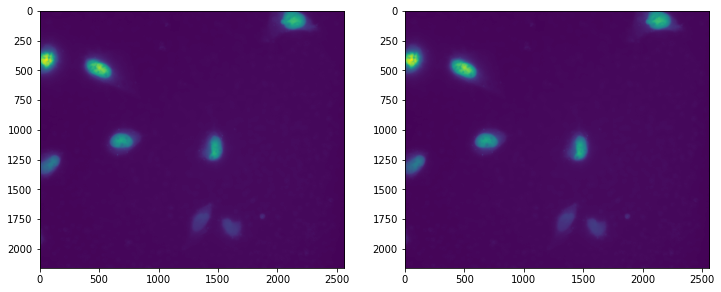

In [22]:
# Example output
figure, figure_axes = plt.subplots(1, 2, figsize = (12, 6))
figure_axes[0].imshow(merfish_images[3])
img = random_intensity_change(merfish_images[3])
figure_axes[1].imshow(img);

In [26]:
# Random gaussian noise, from: https://nbviewer.jupyter.org/github/stardist/stardist/blob/master/examples/2D/2_training.ipynb
def random_noise(img):
    sig = 0.02 * np.random.uniform(0,1)
    img = img + sig * np.random.normal(0, 1, img.shape)
    return img

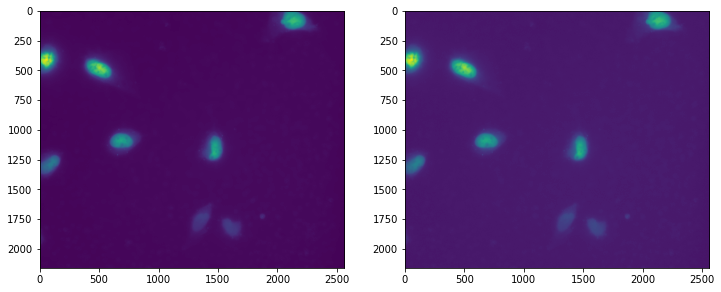

In [27]:
# Example output
figure, figure_axes = plt.subplots(1, 2, figsize = (12, 6))
figure_axes[0].imshow(merfish_images[3])
img = random_noise(merfish_images[3])
figure_axes[1].imshow(img);

Below, I tried to copy nuclei to other parts of the image. This isn't as easy as I thought as StarDist requires normalization of images to floating point values, which means logical operations to set the image values can't be used.

TODO: fix or remove

8
7149


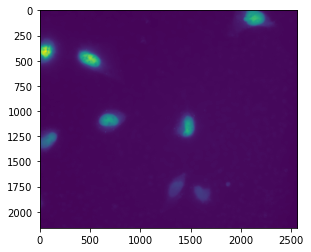

In [144]:
# make binary image
binary = np.copy(merfish_masks[3]) 
binary[binary > 0] = 1

# relabel image to get int labels
labelled_img, total_objs = label(binary, return_num = True)
print(np.max(labelled_img))

# grab one of the objects
obj_2 = np.copy(labelled_img)
obj_2[obj_2 != 2] = 0
for i in range(50):
    obj_2 = np.insert(obj_2, 0, 0, axis = 0)
    obj_2 = np.delete(obj_2, len(obj_2) - 1, 0)
# obj_2 = np.flip(obj_2, axis = 0)
obj_2[obj_2 > 0] = total_objs + 1

# make sure the area we are placing it doesn't have an object there already
mask = np.copy(obj_2)
res = np.logical_and(mask, labelled_img)
print(np.count_nonzero(res))
plt.imshow(res)
actual = np.copy(merfish_images[3]).astype(np.uint64)
plt.imshow(merfish_images[3])

# check if np.count_nonzero(res) == 0, otherwise try the next object

# new = np.logical_or(obj_2, labelled_img)
# print(np.max(new))
# new = new.astype(merfish_masks[3].dtype)
# plt.imshow(new);
# cv.imwrite('../test.tiff', new)